In [1]:
import numpy
import monai

In [2]:
import glob
import nibabel as nib
import numpy as np
from os.path import isfile
import datetime
from IPython.display import clear_output

uncorr_files = glob.glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/*uncorr.nii.gz')
print(uncorr_files)


for f in uncorr_files:
  sub_name = f[:-14]

  corr_file = sub_name + '_corr.nii.gz'
  uncorr_file = sub_name + '_uncorr.nii.gz'
  output_file = sub_name + '_bias.nii.gz'

  if isfile(output_file):
    continue

  print(sub_name)

  # Load the NIfTI images using nibabel
  image1 = nib.load(corr_file).get_fdata()
  image2 = nib.load(uncorr_file).get_fdata().squeeze()



  #when we augment, make sure that the log domain is correctly accounted for

  # Calculate the ratio of the two images
  ratio = np.divide(image2, image1 + 0.1, out=np.zeros_like(image2) ) # added 0.1 to avoid division by 0

  # Save the ratio as a NIfTI file
  ratio_image = nib.Nifti1Image(ratio, affine=nib.load(uncorr_file).affine)  # Assuming no affine transformation
  nib.save(ratio_image, output_file)

  print(f"Ratio image saved as {output_file}")


clear_output()


/home1/ajoshi/.local/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:396: RuntimeWarning: overflow encountered in scalar add
  vmean = .5 * (vmin + vmax)


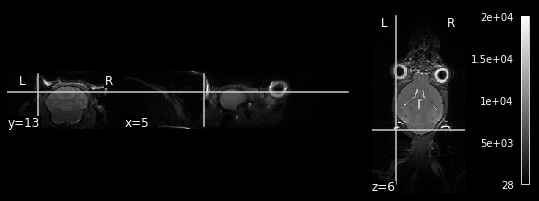

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

#from nilearn.plotting import plot_anat

nifti_file1 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/eae14_08_20_uncorr.nii.gz'
nifti_file2 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/eae14_08_20_corr.nii.gz'
nifti_file3 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/eae14_08_20_bias.nii.gz'

# Load the NIfTI file
#nifti_img = nib.load(nifti_file)

# Plot the image using nilearn
#plotting.view_img(nifti_file1, bg_img=False, cmap='gray', colorbar=True, symmetric_cmap=False)

plotting.plot_anat(nifti_file1, colorbar=True,vmax=2e4,black_bg='k',cut_coords=(5,13,6))

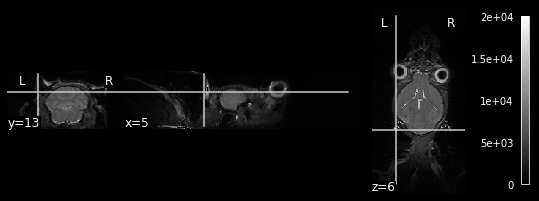

In [4]:
plotting.plot_anat(nifti_file2, colorbar=True, vmax=2e4,cut_coords=(5,13,6))

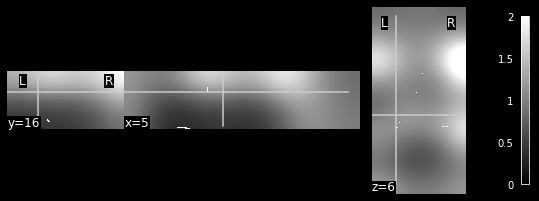

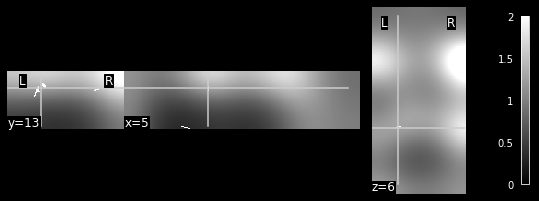

In [5]:
plotting.plot_anat(nifti_file3, colorbar=True, vmax=2,vmin=0,cut_coords=(5,16,6))
plotting.plot_anat(nifti_file3, colorbar=True, vmax=2,vmin=0)

In [6]:
import torch
import monai
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.nn import MSELoss
from monai.data import Dataset, DataLoader, partition_dataset

from monai.transforms import Compose, LoadImaged, AddChanneld, SqueezeDim, SqueezeDimd, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirst, Resize, RandBiasFieldd
from monai.utils import set_determinism
from glob import glob
import random

# Set random seed for reproducibility
set_determinism(seed=0)

# Define your dataset and data loader
class BiasFieldCorrectionDataset(Dataset):
    def __init__(self, image_files, bias_files, transform=None):
        self.image_files = image_files
        self.bias_files = bias_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.transform(self.image_files[idx])
        bias = self.transform(self.bias_files[idx])
        return {'image': image, 'bias': bias}

# Assuming you have a list of paired image and bias file paths
#image_files = ['image1.nii.gz', 'image2.nii.gz']
#bias_files = ['bias_field1.nii.gz', 'bias_field2.nii.gz']

image_files = (glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/*uncorr.nii.gz'))
bias_files = (glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/*bias.nii.gz'))

# Define transformations
#transforms = Compose([LoadImaged(keys=['image', 'bias'],image_only=True), AddChanneld(keys=['image', 'bias']), ToTensord(keys=['image', 'bias'])])
#transforms = Compose([LoadImage(image_only=True), Resize(), EnsureChannelFirst(), ToTensor()])


data_dicts = [{"image": image, "bias": bias} for image, bias in zip(image_files, bias_files)]

random.seed(11)

#random.shuffle(data_dicts)
num_files = len(data_dicts)
num_train_files = round(0.8 * num_files)
train_files = data_dicts[:num_train_files]
val_files = data_dicts[num_train_files:]
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))



total num files: 120
num training files: 96
num validation files: 24


In [7]:

from monai.transforms import Compose, Resized, RandBiasFieldd, ScaleIntensityd,LoadImaged, AddChanneld, EnsureChannelFirstd, RandAffined, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirst, Resize, RandBiasFieldd
from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    pad_list_data_collate,
    TestTimeAugmentation,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

keys = ["image", "bias"]

train_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),
    ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
    RandAffined(
            keys,
            prob=0.5,
            rotate_range=(np.pi / 3, np.pi / 3, np.pi / 3),
            translate_range=(30,30,30),
            scale_range=(0.3,0.3,0.3),shear_range=(.1,.1,.1,.1,.1,.1),
            padding_mode=("zeros","reflection"),
        ),
    Resized(
            keys,
            spatial_size=(64, 64, 64),
    ),
    RandBiasFieldd(keys,prob=0.5, coeff_range=(-1,1)),
])


val_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),    
    ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),    
    Resized(
            keys,
            spatial_size=(64, 64, 64),
    ),
])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=4, num_workers=10, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10, collate_fn=pad_list_data_collate)



Loading dataset: 100%|██████████| 96/96 [00:06<00:00, 14.20it/s]
/home1/ajoshi/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 24/24 [00:01<00:00, 13.83it/s]


/home1/ajoshi/.local/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home1/ajoshi/.local/lib/python3.9/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)
/home1/ajoshi/.local/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage cla

0


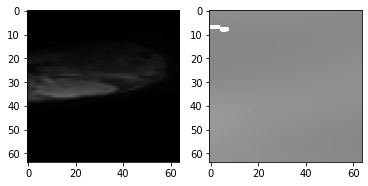

1


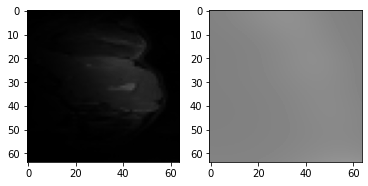

2


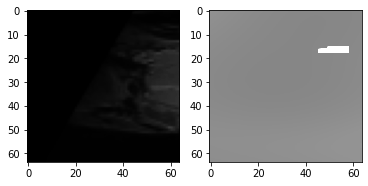

3


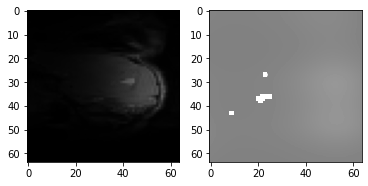

0


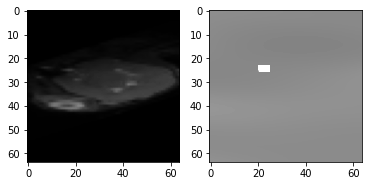

1


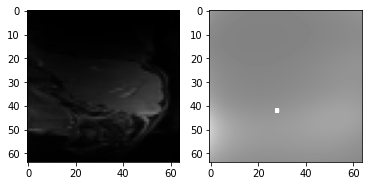

2


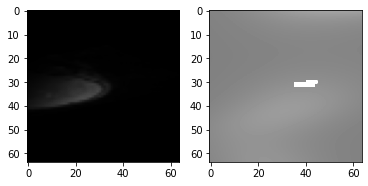

3


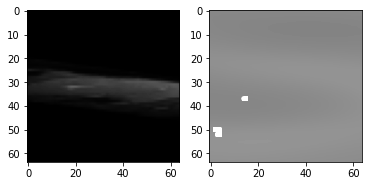

0


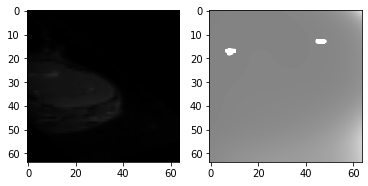

1


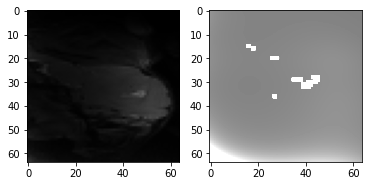

2


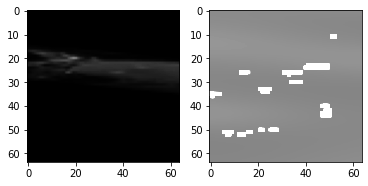

3


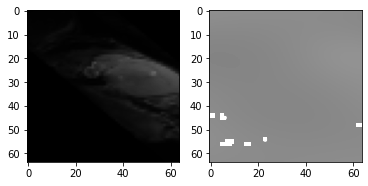

0


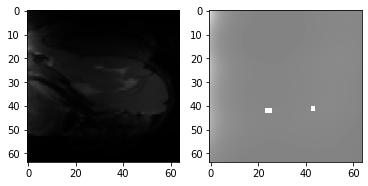

1


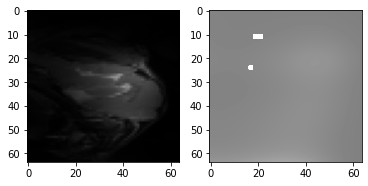

2


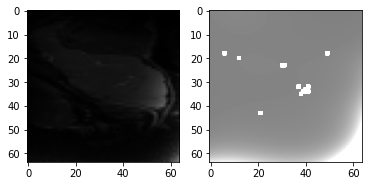

3


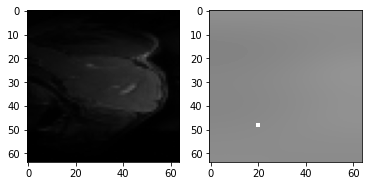

0


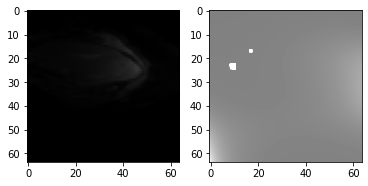

1


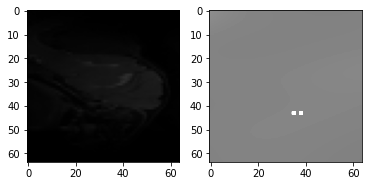

2


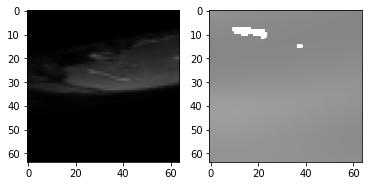

3


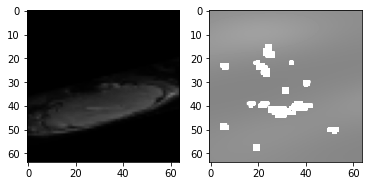

0


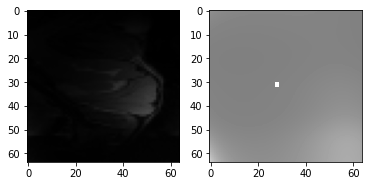

1


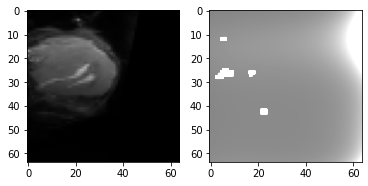

2


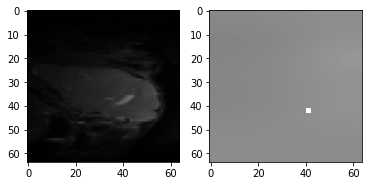

3


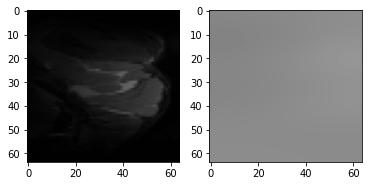

0


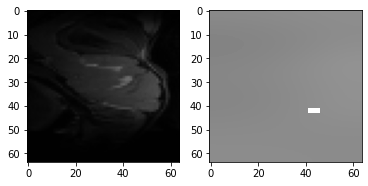

1


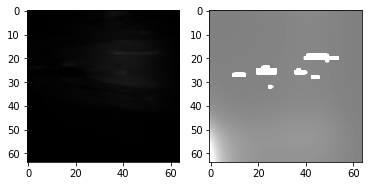

2


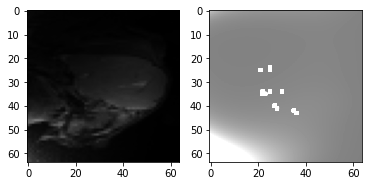

3


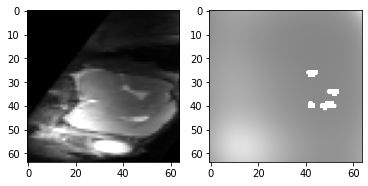

0


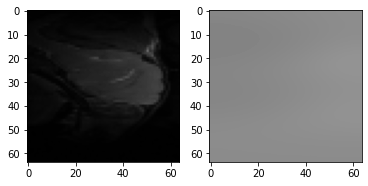

1


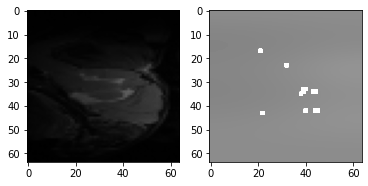

2


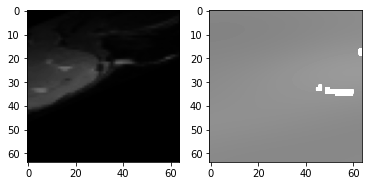

3


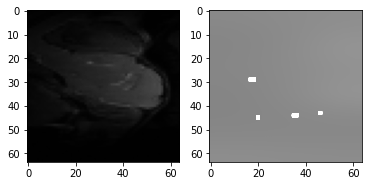

0


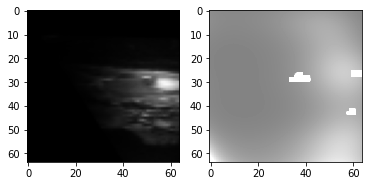

1


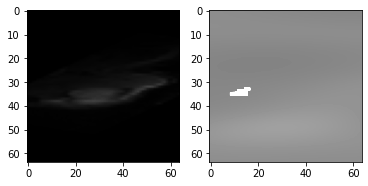

2


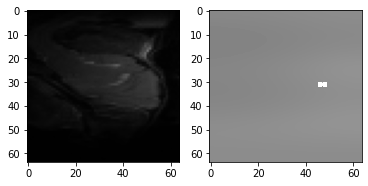

3


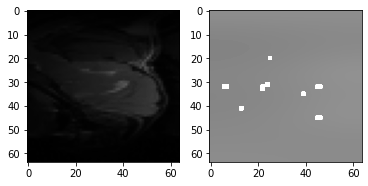

0


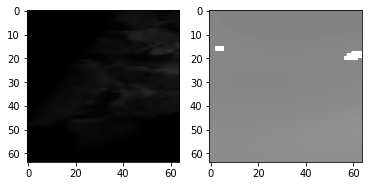

1


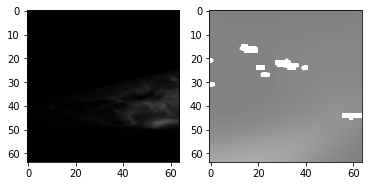

2


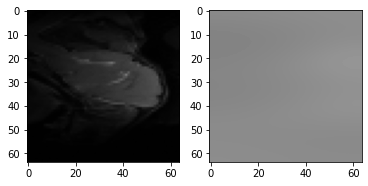

3


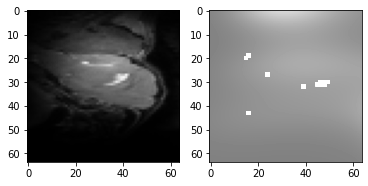

0


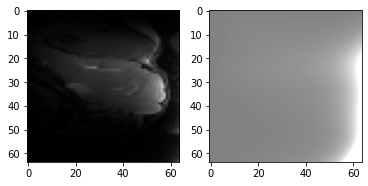

1


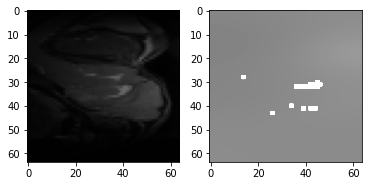

2


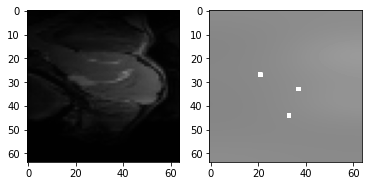

3


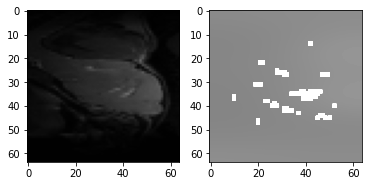

0


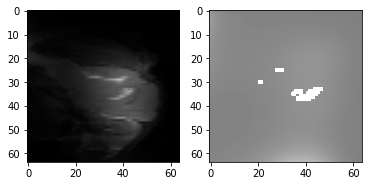

1


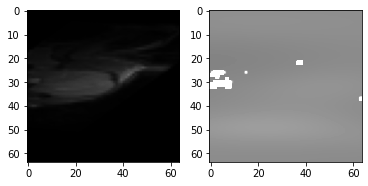

2


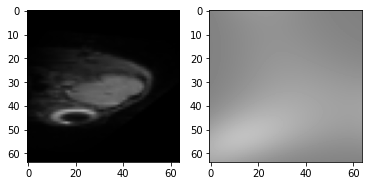

3


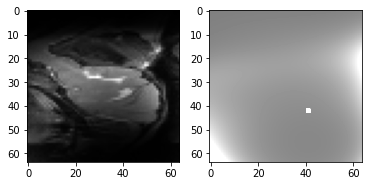

0


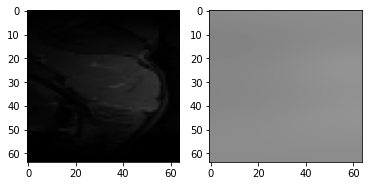

1


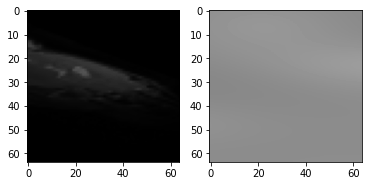

2


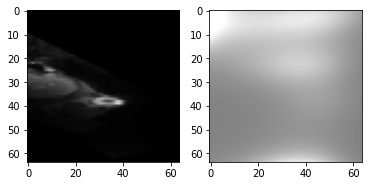

3


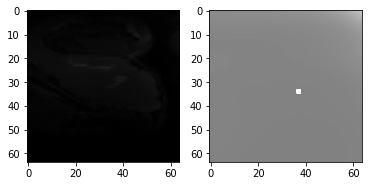

0


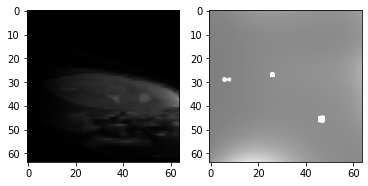

1


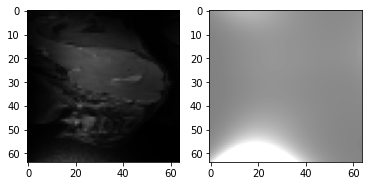

2


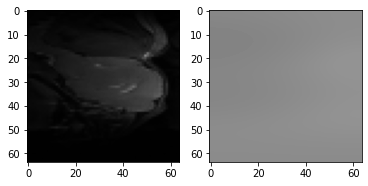

3


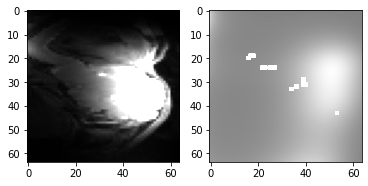

0


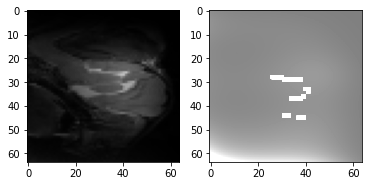

1


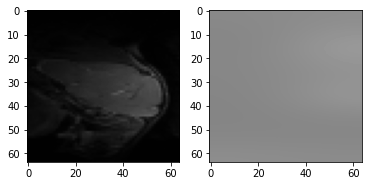

2


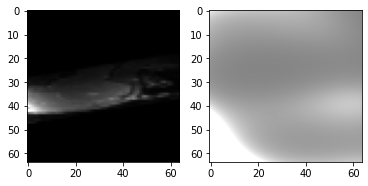

3


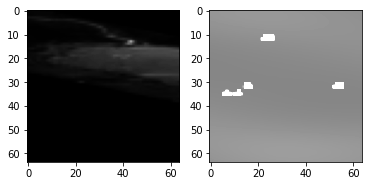

0


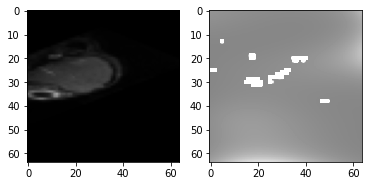

1


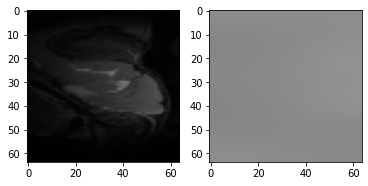

2


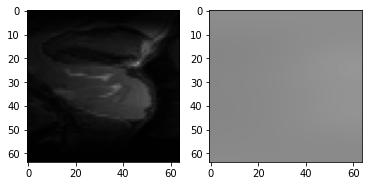

3


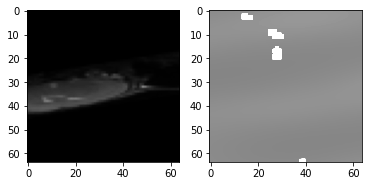

0


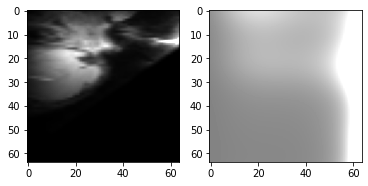

1


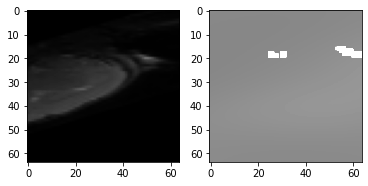

2


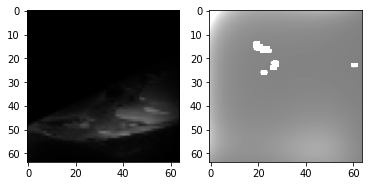

3


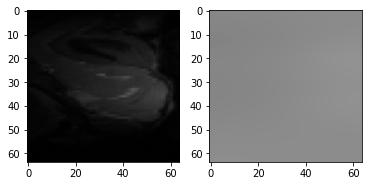

0


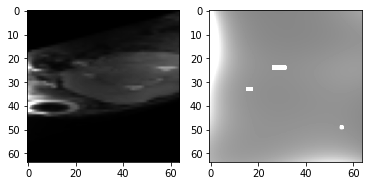

1


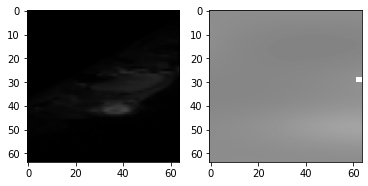

2


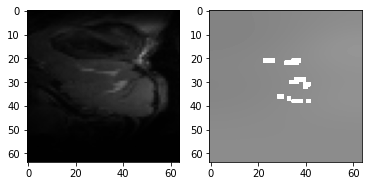

3


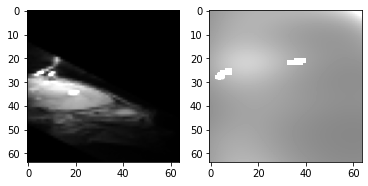

0


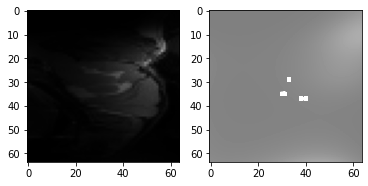

1


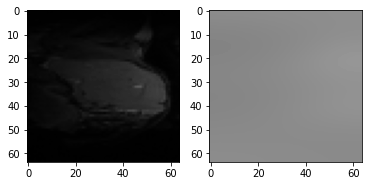

2


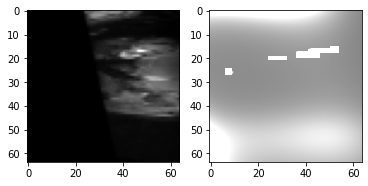

3


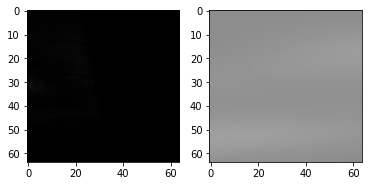

0


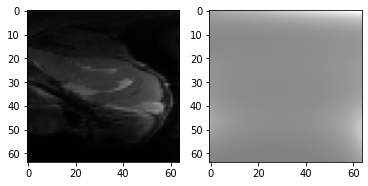

1


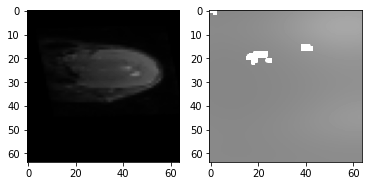

2


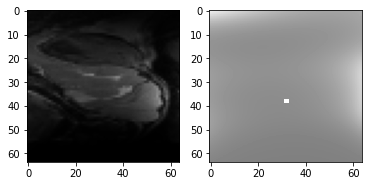

3


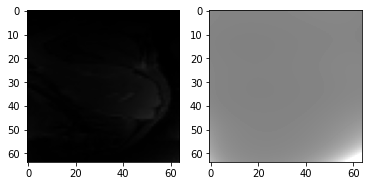

In [8]:

batch = next(iter(train_loader))

i=0
for batch in train_loader:
    i += 1
    if i>20:
        break
        
    for j in range(4):
        print(j)
        plt.subplot(121)
        plt.imshow(batch['image'][j,0,32,:,:],cmap='gray',vmin=0,vmax=1)
        plt.subplot(122)
        plt.imshow(batch['bias'][j,0,32,:,:],cmap='gray',vmin=-10,vmax=10)

        plt.show()





In [ ]:


# Create dataset and data loader
#dataset = BiasFieldCorrectionDataset(image_files, bias_files, transform=transforms)


# Split the dataset into training and validation sets


# Create data loaders for training and validation
#train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define the UNet model and optimizer

# Specify spatial_dims and strides for 3D data
spatial_dims = 3
strides = (1, 1, 1, 1)

model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,  # Adjust based on your data
    out_channels=1, # Adjust based on your data
    channels=(2,8,8,16,32),#(16, 64, 64, 128, 256),
    strides=strides,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the Dice loss
loss_function = MSELoss() # DiceLoss(sigmoid=True)

# Training loop
num_epochs = 10002
save_interval = 500

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:

        inputs, biases = batch['image'].to(device), torch.log(batch['bias']).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, biases)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_train_loss / len(train_loader)}")


    # Validation loop
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            inputs, biases = batch['image'].to(device), torch.log(batch['bias']).to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, biases)
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {total_val_loss / len(val_loader)}")


    if epoch % save_interval == 0:

        current_datetime = datetime.datetime.now()
        
        # Format the date and time as a string
        formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
        
        # Create a filename with the formatted date and time
        filename = f"/project/ajoshi_27/code_farm/rodbfc/models/bias_field_correction_model_{formatted_datetime}_epoch_{epoch}.pth"
        
        # Save the trained model
        torch.save(model.state_dict(), filename)



Epoch 1/10002, Training Loss: 1.0846031171580155
Epoch 1/10002, Validation Loss: 0.25077233525613946
Epoch 2/10002, Training Loss: 0.8989337210853895
Epoch 2/10002, Validation Loss: 0.2545743404577176
Epoch 3/10002, Training Loss: 0.9266679162780443
Epoch 3/10002, Validation Loss: 0.2344838666419188
Epoch 4/10002, Training Loss: 1.0309967442105215
Epoch 4/10002, Validation Loss: 0.23301172442734241
Epoch 5/10002, Training Loss: 1.0775057015319665
Epoch 5/10002, Validation Loss: 0.27431341260671616
Epoch 6/10002, Training Loss: 0.9667851875225703
Epoch 6/10002, Validation Loss: 0.2179204070319732
Epoch 7/10002, Training Loss: 1.0385408823688824
Epoch 7/10002, Validation Loss: 0.23366492862502733
Epoch 8/10002, Training Loss: 1.026322800045212
Epoch 8/10002, Validation Loss: 0.19826811210562786
Epoch 9/10002, Training Loss: 1.085368995865186
Epoch 9/10002, Validation Loss: 0.2793924876799186
Epoch 10/10002, Training Loss: 0.7933566458523273
Epoch 10/10002, Validation Loss: 0.240772871300

In [ ]:
try:
  import monai
except:
  !pip install monai pytorch-gpu nilearn
  import monai

import numpy as np
import nibabel as nib
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.nn import MSELoss
from monai.data import Dataset, DataLoader, partition_dataset

from monai.transforms import Compose, LoadImaged, AddChanneld, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirstd, Resized, Resize, RandBiasFieldd
from monai.utils import set_determinism
from glob import glob
import random
import matplotlib.pyplot as plt


# Define the UNet model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify spatial_dims and strides for 3D data
spatial_dims = 3
strides = (1, 1, 1, 1)

model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,  # Adjust based on your data
    out_channels=1, # Adjust based on your data
    channels=(2,8,8,16,32),#(16, 64, 64, 128, 256)/8,
    strides=strides,
).to(device)



keys=["image"]

test_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),
    Resized(
            keys,
            spatial_size=(64, 64, 64),
        ),
   # RandBiasField(prob=1, coeff_range=(0.2,0.3)),
    #ToTensor(),
])

model.eval()

# Load the test image (adjust the path to your validation image)
test_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/3_RC_uncorr.nii.gz'
test_ground_truth_corrected_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/3_RC_corr.nii.gz'
test_corrected_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/3_RC_uncorr.bfc.nii.gz'
model_file='models/bias_field_correction_model_2023-09-17_02-55-00.pth'

model.load_state_dict(torch.load(model_file))


test_dict = [{"image":test_image_path}]
#test_dict = [{"image": image, "bias": bias} for image, bias in zip(image_files, bias_files)]
# Apply transformations to the validation image
test_image = test_transforms(test_dict)[0]["image"].to(device)

# Apply the trained model to estimate the bias field
with torch.no_grad():
    estimated_bias_field = model(test_image[None,])

# Convert the estimated bias field to a Numpy array
estimated_bias_field = estimated_bias_field.squeeze().cpu().numpy()

print(estimated_bias_field.shape)
# Load the original validation image without resizing (for displaying the corrected image)
original_test_image = nib.load(test_image_path).get_fdata().squeeze()
original_test_corrected_image = nib.load(test_ground_truth_corrected_image_path).get_fdata().squeeze()

orig_shape = original_test_image.shape

print(orig_shape)

estimated_bias_field_resized = Resize(spatial_size=orig_shape)(estimated_bias_field[None,])[0]

print(estimated_bias_field_resized.shape)
# Apply the estimated bias field to correct the original image
corrected_image = original_test_image / np.exp(estimated_bias_field_resized)

# Display the original image, estimated bias field, and corrected image
plt.figure(figsize=(12, 4))
plt.subplot(221)
plt.title("Original Image")
plt.imshow(original_test_image[:, original_test_image.shape[1] // 2, :].T, cmap='gray')

plt.subplot(222)
plt.title("Estimated Bias Field")
plt.imshow(estimated_bias_field_resized[:, estimated_bias_field_resized.shape[1] // 2, :].T, cmap='gray')

plt.subplot(223)
plt.title("Corrected Estimated Image")
plt.imshow(corrected_image[:, corrected_image.shape[1] // 2, :].T, cmap='gray')

plt.subplot(224)
plt.title("Corrected GT Image")
plt.imshow(original_test_corrected_image[:, original_test_image.shape[1] // 2, :].T, cmap='gray')



plt.show()

input_nifti = nib.load(test_image_path)
input_dtype = input_nifti.get_data_dtype()
corrected_image = corrected_image.astype(input_dtype)


# Create a new NIfTI image with the result data
result_nifti = nib.Nifti1Image(corrected_image, input_nifti.affine)

# Save the result as a new NIfTI image
nib.save(result_nifti, test_corrected_image_path)


